In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-crashes/Traffic_Crashes_-_People_20241006.csv
/kaggle/input/traffic-crashes/Traffic_Crashes_-_Crashes_20241006.csv
/kaggle/input/traffic-crashes/Traffic_Crashes_-_Vehicles_20241009.csv


In [2]:
# Import other dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Loading Datasets

1. **Crashes Dataset**

In [3]:
crashes_df = pd.read_csv('/kaggle/input/traffic-crashes/Traffic_Crashes_-_Crashes_20241006.csv')

crashes_df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,NaN,09/05/2023 07:05:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",...,2.0,0.0,2.0,0.0,19,3,9,NaN,NaN,NaN
1,2675c13fd0f474d730a5b780968b3cafc7c12d7adb661f...,NaN,09/22/2023 06:45:00 PM,50,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN BARRIER,...,0.0,0.0,2.0,0.0,18,6,9,NaN,NaN,NaN
2,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,NaN,07/29/2023 02:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,1.0,0.0,14,7,7,41.85412,-87.665902,POINT (-87.665902342962 41.854120262952)
3,7ebf015016f83d09b321afd671a836d6b148330535d5df...,NaN,08/09/2023 11:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,23,4,8,NaN,NaN,NaN
4,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,NaN,08/18/2023 12:50:00 PM,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,...,1.0,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN


We are first going to create 2 functions:
* One that summarises missing values
* Another for dropping any column in our datasets whose missing values are above our set threshold 75%

In [4]:
def missing_values_summary(df):
    # Calculate the number of missing values and their percentage
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / df.shape[0]) * 100
    
    # Create a DataFrame with the results
    missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

    # Filter out columns with no missing values and sort by 'Missing Values'
    missing_data = missing_data[missing_data['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)

    return missing_data

In [5]:
def drop_high_missing_columns(df, threshold=75):
    # Calculate the percentage of missing values
    missing_percentage = (df.isnull().sum() / df.shape[0]) * 100

    # Filter columns with missing percentage greater than the threshold
    columns_to_drop = missing_percentage[missing_percentage > threshold].index

    # Drop the columns
    df_dropped = df.drop(columns=columns_to_drop)

    return df_dropped

#### **Exploring Crashes Dataset**

Checking the columns we have in our `Crashes` dataset

In [6]:
crashes_df.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 

In [7]:
# Check the number of rows and columns 
crashes_df.shape

(880093, 48)

From the above output, we can note that we have 880093 rows and 48 columns

In [8]:
crashes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880093 entries, 0 to 880092
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                880093 non-null  object 
 1   CRASH_DATE_EST_I               65222 non-null   object 
 2   CRASH_DATE                     880093 non-null  object 
 3   POSTED_SPEED_LIMIT             880093 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         880093 non-null  object 
 5   DEVICE_CONDITION               880093 non-null  object 
 6   WEATHER_CONDITION              880093 non-null  object 
 7   LIGHTING_CONDITION             880093 non-null  object 
 8   FIRST_CRASH_TYPE               880093 non-null  object 
 9   TRAFFICWAY_TYPE                880093 non-null  object 
 10  LANE_CNT                       199017 non-null  float64
 11  ALIGNMENT                      880093 non-null  object 
 12  ROADWAY_SURFACE_COND          

Using our function to check on columns with missing values in descending order

In [9]:
missing_values_summary(crashes_df)

,Missing Values,Percentage
WORKERS_PRESENT_I,878817,99.855015
DOORING_I,877309,99.683670
WORK_ZONE_TYPE,876260,99.564478
WORK_ZONE_I,875130,99.436082
PHOTOS_TAKEN_I,868157,98.643780
STATEMENTS_TAKEN_I,859949,97.711151
NOT_RIGHT_OF_WAY_I,839883,95.431165
CRASH_DATE_EST_I,814871,92.589192
LANE_CNT,681076,77.386822
INTERSECTION_RELATED_I,678237,77.064242


We have features with more than 75% missing values and for this reason they are going to be dropped and after which, all the null values are also going to be dropped so that we remain with clean `Crashes` dataset

Let's look at the statistical summary

In [10]:
# Statistical summary
crashes_df.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,880093.000000,1.990170e+05,880093.000000,880088.000000,880093.000000,878152.000000,878152.000000,878152.000000,878152.000000,878152.000000,878152.000000,878152.0,880093.000000,880093.000000,880093.000000,873822.000000,873822.000000
mean,28.418012,1.332970e+01,3687.502824,1244.779543,2.035159,0.193529,0.001189,0.019830,0.108621,0.063889,2.001315,0.0,13.204356,4.121138,6.641602,41.855119,-87.673679
std,6.121844,2.961542e+03,2880.803121,705.000740,0.452488,0.571493,0.037376,0.164983,0.425074,0.324960,1.157131,0.0,5.572912,1.981148,3.363514,0.334180,0.678922
min,0.000000,0.000000e+00,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.936193
25%,30.000000,2.000000e+00,1250.000000,715.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,4.000000,41.783061,-87.721824
50%,30.000000,2.000000e+00,3201.000000,1212.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.874952,-87.674226
75%,30.000000,4.000000e+00,5564.000000,1822.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,9.000000,41.924519,-87.633513
max,99.000000,1.191625e+06,451100.000000,6100.000000,18.000000,21.000000,4.000000,10.000000,21.000000,15.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


Dropping features with missing values above 75% threshold

In [11]:
crashes_df = drop_high_missing_columns(crashes_df, threshold=75)

Having a look at the missing values summary after dropping the features

In [12]:
missing_values_summary(crashes_df)

,Missing Values,Percentage
HIT_AND_RUN_I,604145,68.645586
REPORT_TYPE,27030,3.071266
LOCATION,6271,0.712538
LONGITUDE,6271,0.712538
LATITUDE,6271,0.712538
MOST_SEVERE_INJURY,1955,0.222136
INJURIES_FATAL,1941,0.220545
INJURIES_TOTAL,1941,0.220545
INJURIES_NO_INDICATION,1941,0.220545
INJURIES_REPORTED_NOT_EVIDENT,1941,0.220545


#### **Exploring People Dataset**

Checking the columns of `People` dataset

In [13]:
people_df = pd.read_csv('/kaggle/input/traffic-crashes/Traffic_Crashes_-_People_20241006.csv', low_memory=False)

people_df.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,M,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,IMPROPER BACKING,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


In [14]:
people_df.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

In [15]:
# Checking the number of columns and rows
people_df.shape

(1932814, 29)

From the output, we have 1932814 rows and 29 columns

In [16]:
# Dataset information
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932814 entries, 0 to 1932813
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   PERSON_ID              object 
 1   PERSON_TYPE            object 
 2   CRASH_RECORD_ID        object 
 3   VEHICLE_ID             float64
 4   CRASH_DATE             object 
 5   SEAT_NO                float64
 6   CITY                   object 
 7   STATE                  object 
 8   ZIPCODE                object 
 9   SEX                    object 
 10  AGE                    float64
 11  DRIVERS_LICENSE_STATE  object 
 12  DRIVERS_LICENSE_CLASS  object 
 13  SAFETY_EQUIPMENT       object 
 14  AIRBAG_DEPLOYED        object 
 15  EJECTION               object 
 16  INJURY_CLASSIFICATION  object 
 17  HOSPITAL               object 
 18  EMS_AGENCY             object 
 19  EMS_RUN_NO             object 
 20  DRIVER_ACTION          object 
 21  DRIVER_VISION          object 
 22  PHYSICAL_CONDITION

Check on the missing values summary in descending order

In [17]:
missing_values_summary(people_df)

,Missing Values,Percentage
CELL_PHONE_USE,1931654,99.939984
BAC_RESULT VALUE,1930698,99.890522
EMS_RUN_NO,1900336,98.319652
PEDPEDAL_VISIBILITY,1895221,98.055012
PEDPEDAL_ACTION,1895153,98.051494
PEDPEDAL_LOCATION,1895153,98.051494
EMS_AGENCY,1738265,89.934417
HOSPITAL,1617886,83.706244
SEAT_NO,1541715,79.765306
DRIVERS_LICENSE_CLASS,991106,51.277878


In [18]:
# Statistical summary
people_df.describe()

,VEHICLE_ID,SEAT_NO,AGE,BAC_RESULT VALUE
count,1.893365e+06,391099.000000,1.369426e+06,2116.000000
mean,9.094490e+05,4.164818,3.791410e+01,0.170747
std,5.288295e+05,2.216350,1.708989e+01,0.103180
min,2.000000e+00,1.000000,-1.770000e+02,0.000000
25%,4.512990e+05,3.000000,2.500000e+01,0.120000
50%,9.004650e+05,3.000000,3.500000e+01,0.170000
75%,1.369158e+06,5.000000,5.000000e+01,0.220000
max,1.830378e+06,12.000000,1.100000e+02,1.000000


Drop columns whose missing values are above 75% threshold

In [19]:
people_df = drop_high_missing_columns(people_df, threshold=75)

Re-check the missing values summary after dropping the columns

In [20]:
missing_values_summary(people_df)

,Missing Values,Percentage
DRIVERS_LICENSE_CLASS,991106,51.277878
DRIVERS_LICENSE_STATE,801540,41.470105
ZIPCODE,639846,33.104375
AGE,563388,29.148589
CITY,526566,27.243491
STATE,505205,26.138314
DRIVER_VISION,395153,20.444440
DRIVER_ACTION,394562,20.413863
BAC_RESULT,393617,20.364970
PHYSICAL_CONDITION,393509,20.359383


#### **Exploring Vehicle Dataset**

In [21]:
vehicle_df = pd.read_csv('/kaggle/input/traffic-crashes/Traffic_Crashes_-_Vehicles_20241009.csv')

vehicle_df.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,1717556,7b1763088507f77e0e552c009a6bf89a4d6330c7527706...,12/06/2023 03:24:00 PM,1,DRIVER,NaN,1634931.0,NaN,NISSAN,SENTRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1717574,2603ff5a88f0b9b54576934c5ed4e4a64e8278e005687b...,12/06/2023 04:00:00 PM,2,DRIVER,NaN,1634978.0,NaN,CHRYSLER,SEBRING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1717579,a52ef70e33d468b855b5be44e8638a564434dcf99c0edf...,12/06/2023 04:30:00 PM,1,DRIVER,NaN,1634948.0,NaN,SUBARU,OUTBACK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1720118,609055f4b1a72a44d6ec40ba9036cefd7c1287a755eb6c...,12/10/2023 12:12:00 PM,1,DRIVER,NaN,1637401.0,NaN,TOYOTA,RAV4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1720119,609055f4b1a72a44d6ec40ba9036cefd7c1287a755eb6c...,12/10/2023 12:12:00 PM,2,DRIVER,NaN,1637408.0,NaN,SUBARU,OUTBACK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check the columns in `Vehicle` dataset

In [22]:
vehicle_df.columns

Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER',
       'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY',
       'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I',
       'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I',
       'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',
       'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO',
       'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE',
       'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO',
       'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I',
       'TRAILER1_

In [23]:
# Cheeck the number of columns and rows
vehicle_df.shape

(1797799, 71)

from the above output, we have 1797799 rows and 71 columns

In [24]:
# Data information
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797799 entries, 0 to 1797798
Data columns (total 71 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   CRASH_UNIT_ID             int64  
 1   CRASH_RECORD_ID           object 
 2   CRASH_DATE                object 
 3   UNIT_NO                   int64  
 4   UNIT_TYPE                 object 
 5   NUM_PASSENGERS            float64
 6   VEHICLE_ID                float64
 7   CMRC_VEH_I                object 
 8   MAKE                      object 
 9   MODEL                     object 
 10  LIC_PLATE_STATE           object 
 11  VEHICLE_YEAR              float64
 12  VEHICLE_DEFECT            object 
 13  VEHICLE_TYPE              object 
 14  VEHICLE_USE               object 
 15  TRAVEL_DIRECTION          object 
 16  MANEUVER                  object 
 17  TOWED_I                   object 
 18  FIRE_I                    object 
 19  OCCUPANT_CNT              float64
 20  EXCEED_SPEED_LIMIT_I    

Let's look at the missing values summary for the `Vehicle` dataset

In [25]:
missing_values_summary(vehicle_df)

,Missing Values,Percentage
HAZMAT_REPORT_NO,1797798,99.999944
MCS_REPORT_NO,1797792,99.999611
HAZMAT_NAME,1797736,99.996496
TRAILER2_LENGTH,1797729,99.996106
WIDE_LOAD_I,1797638,99.991045
...,...,...
VEHICLE_USE,41925,2.332018
MANEUVER,41925,2.332018
TRAVEL_DIRECTION,41925,2.332018
OCCUPANT_CNT,41925,2.332018


In [26]:
# Statistical summary
vehicle_df.describe()

,CRASH_UNIT_ID,UNIT_NO,NUM_PASSENGERS,VEHICLE_ID,VEHICLE_YEAR,OCCUPANT_CNT,CMV_ID,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT
count,1.797799e+06,1.797799e+06,266268.000000,1.755874e+06,1.476152e+06,1.755874e+06,18167.000000,2416.000000,70.000000,2936.000000,4435.000000
mean,9.614945e+05,3.666488e+00,1.471093,9.143192e+05,2.014236e+03,1.079378e+00,10131.107282,48.467715,44.271429,53.193120,9.568658
std,5.565258e+05,2.817703e+03,1.059615,5.283028e+05,1.377143e+02,7.823757e-01,5855.378574,20.651355,28.008240,31.252969,390.504878
min,2.000000e+00,0.000000e+00,1.000000,2.000000e+00,1.900000e+03,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.786945e+05,1.000000e+00,1.000000,4.571452e+05,2.007000e+03,1.000000e+00,4999.500000,45.000000,24.250000,35.000000,2.000000
50%,9.628840e+05,2.000000e+00,1.000000,9.125875e+05,2.013000e+03,1.000000e+00,10160.000000,53.000000,50.000000,53.000000,3.000000
75%,1.443742e+06,2.000000e+00,2.000000,1.371259e+06,2.017000e+03,1.000000e+00,15220.000000,53.000000,53.000000,66.000000,5.000000
max,1.923912e+06,3.778035e+06,59.000000,1.832862e+06,9.999000e+03,9.900000e+01,20212.000000,740.000000,123.000000,999.000000,26009.000000


Drop the columns with missing values above the 75% threshold

In [27]:
vehicle_df = drop_high_missing_columns(vehicle_df, threshold=75)

Re-check the missing values summary

In [28]:
missing_values_summary(vehicle_df)

,Missing Values,Percentage
AREA_01_I,1315796,73.189272
VEHICLE_YEAR,321647,17.891155
LIC_PLATE_STATE,202695,11.274620
FIRST_CONTACT_POINT,45068,2.506843
MODEL,42075,2.340362
MAKE,41930,2.332296
TRAVEL_DIRECTION,41925,2.332018
VEHICLE_ID,41925,2.332018
VEHICLE_DEFECT,41925,2.332018
VEHICLE_TYPE,41925,2.332018


In [29]:
crashes_ = crashes_df.drop(['CRASH_DATE', 'REPORT_TYPE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 
                            'INJURIES_UNKNOWN', 'LATITUDE', 'LONGITUDE', 'LOCATION'], axis=1)

In [30]:
# display numerical variables

crashes_eda = [col for col in crashes_.columns if crashes_[col].dtypes != 'O']

crashes_eda

['POSTED_SPEED_LIMIT',
 'BEAT_OF_OCCURRENCE',
 'NUM_UNITS',
 'INJURIES_TOTAL',
 'INJURIES_FATAL',
 'INJURIES_INCAPACITATING',
 'INJURIES_NON_INCAPACITATING',
 'INJURIES_REPORTED_NOT_EVIDENT',
 'INJURIES_NO_INDICATION',
 'CRASH_HOUR',
 'CRASH_DAY_OF_WEEK',
 'CRASH_MONTH']

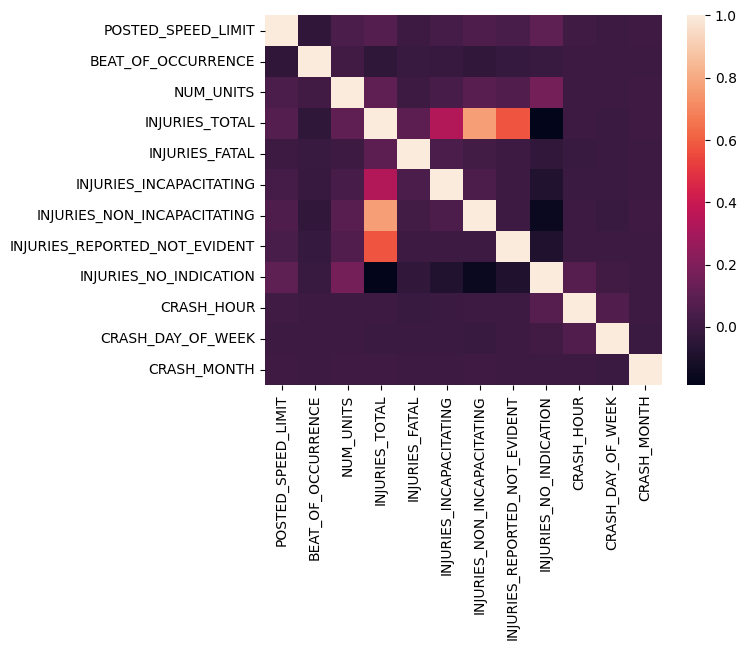

In [31]:
# Are certain factors correlated with severity of injuries?
sns.heatmap(crashes_[crashes_eda].corr());

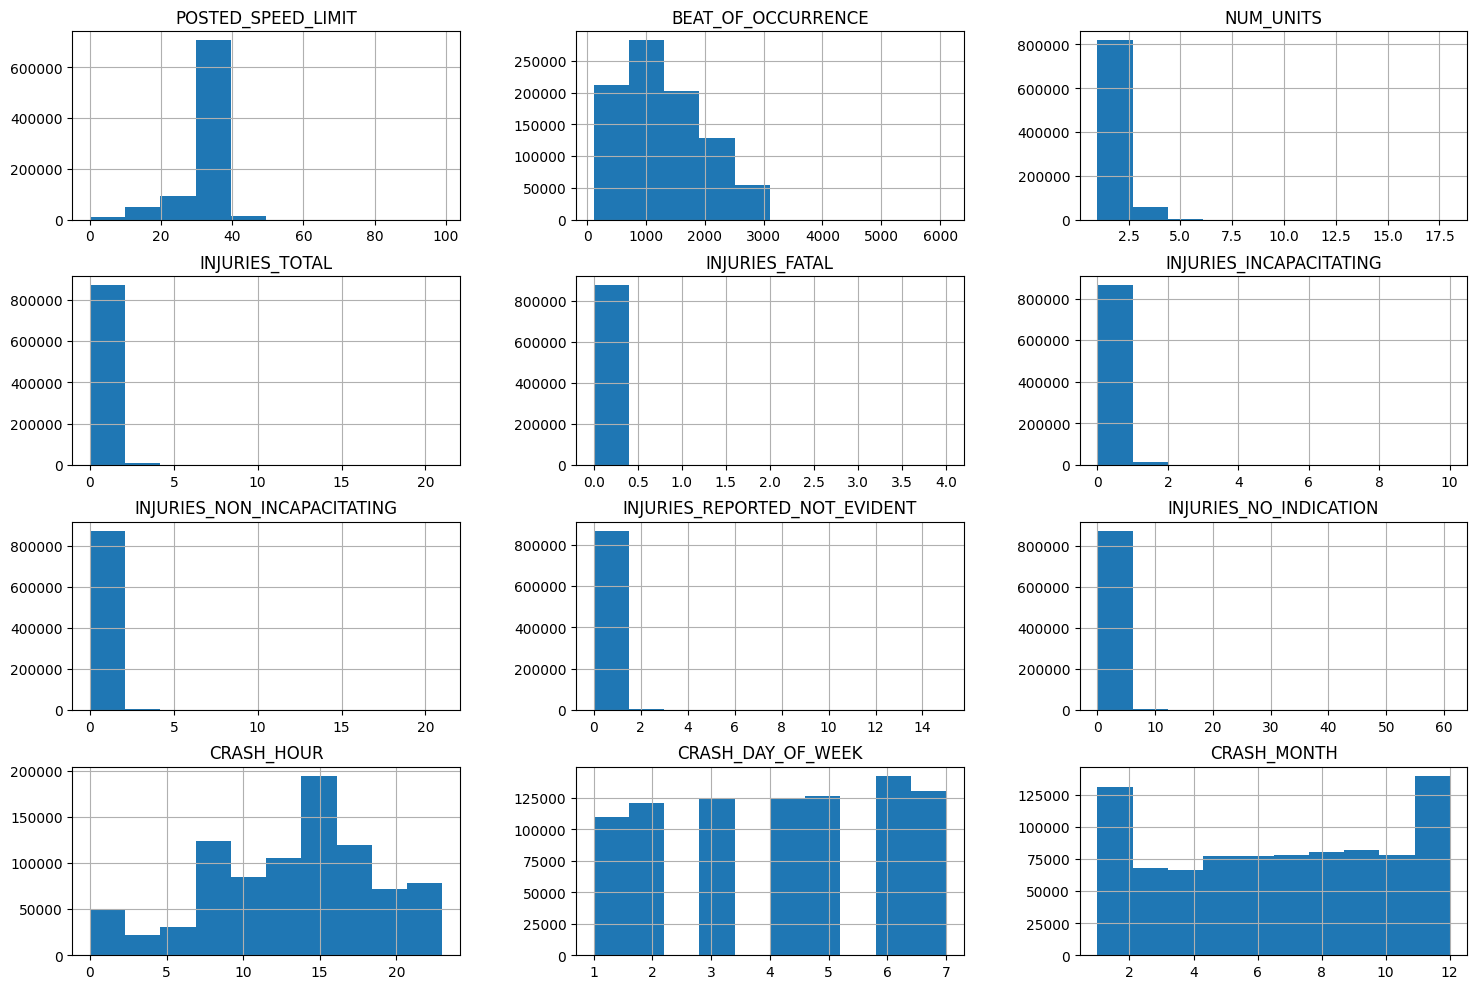

In [32]:
# Numeric variables
crashes_[crashes_eda].hist(figsize=(18, 12));

In [33]:
people_df.INJURY_CLASSIFICATION.value_counts()

INJURY_CLASSIFICATION
NO INDICATION OF INJURY     1761303
NONINCAPACITATING INJURY      95821
REPORTED, NOT EVIDENT         56333
INCAPACITATING INJURY         17549
FATAL                          1065
Name: count, dtype: int64

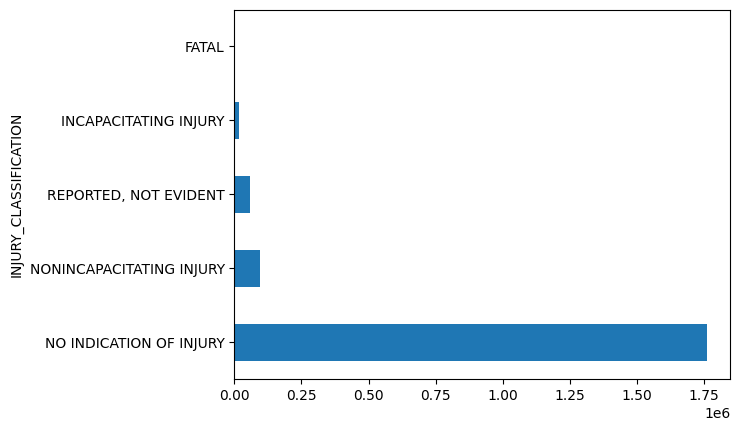

In [34]:
people_df.INJURY_CLASSIFICATION.value_counts().plot.barh();

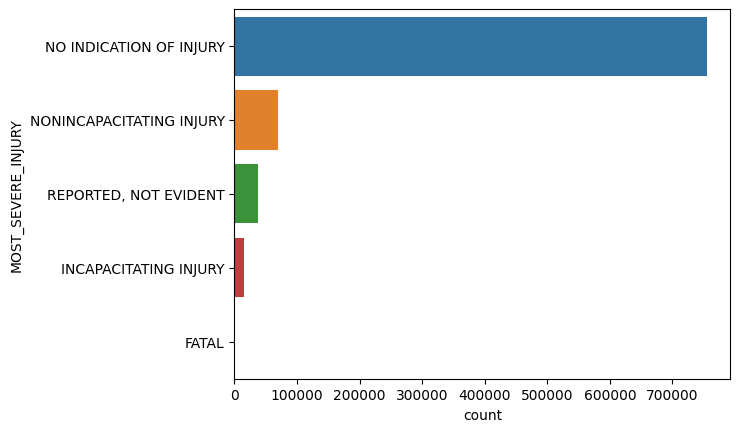

In [35]:
# Target values by crash
sns.barplot(y=crashes_.MOST_SEVERE_INJURY.value_counts().index, 
            x=crashes_.MOST_SEVERE_INJURY.value_counts(),
            orient='h');

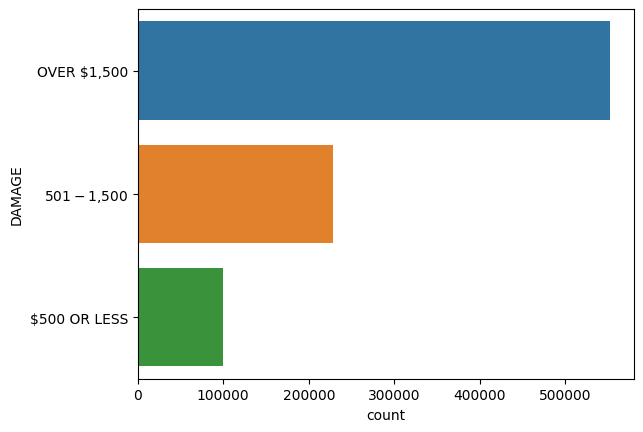

In [36]:
# Total damage in dollars
sns.barplot(y=crashes_.DAMAGE.value_counts().index, x=crashes_.DAMAGE.value_counts(), orient='h');

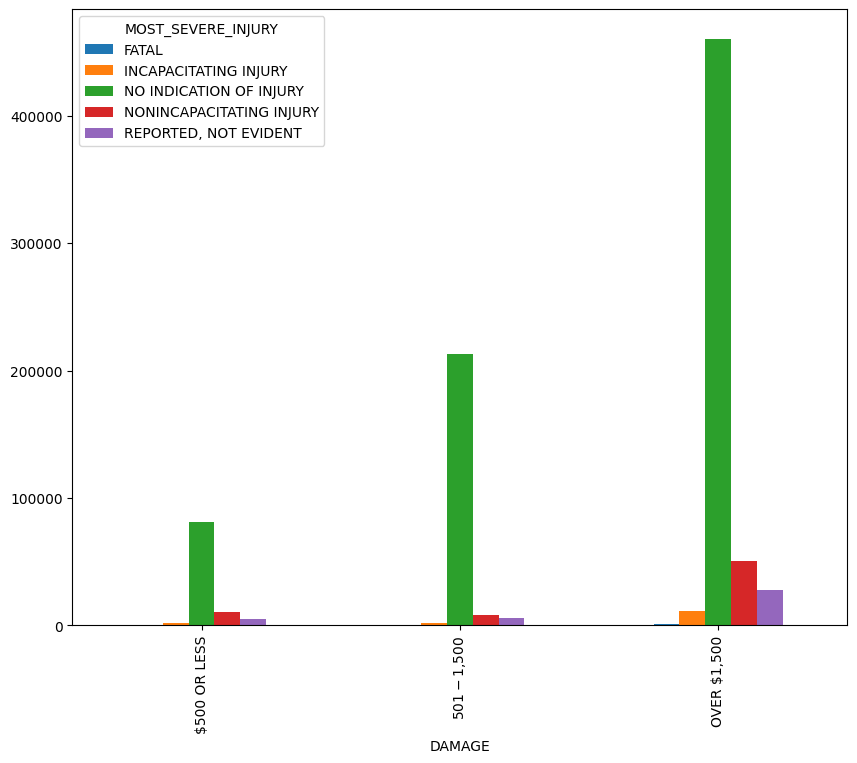

In [37]:
# Total damage disaggregated by most severe injury resulting from a crash
pd.crosstab(crashes_.DAMAGE, crashes_.MOST_SEVERE_INJURY).plot.bar(figsize=(10, 8));

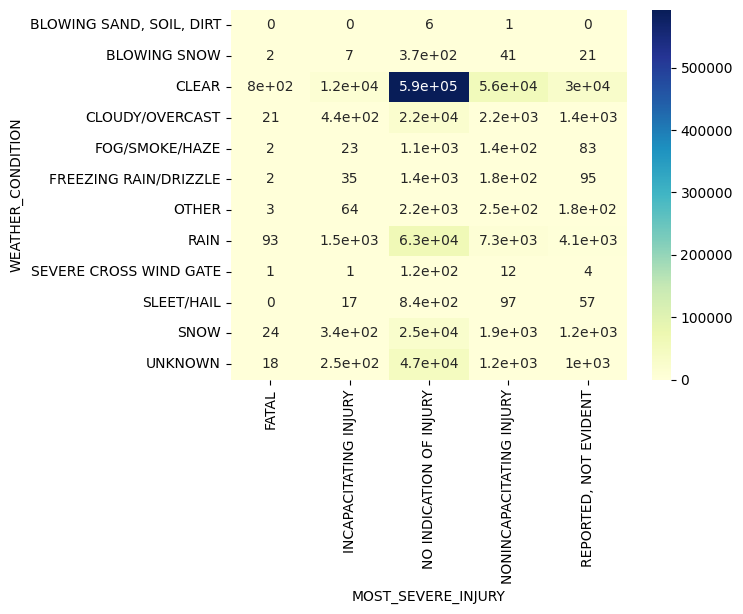

In [38]:
# How might weather affect the severity of injury resulting from a crash?
sns.heatmap(pd.crosstab(crashes_.WEATHER_CONDITION, 
                        crashes_.MOST_SEVERE_INJURY), 
            annot=True, cmap="YlGnBu");

In [39]:
people_ = people_df.drop(['PERSON_ID'], axis=1)

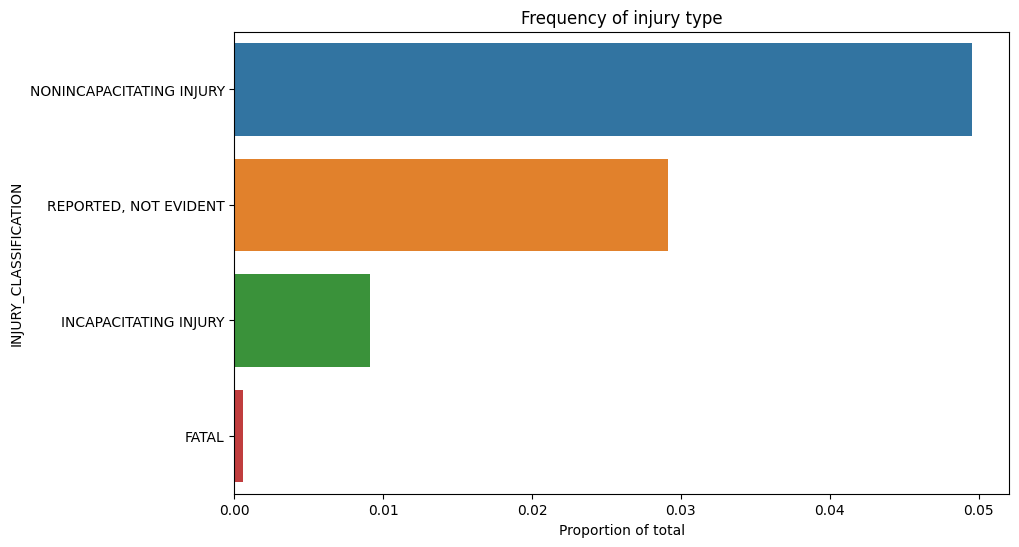

In [40]:
# Distribution of our target classes
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=people_df.INJURY_CLASSIFICATION.value_counts(normalize=True).drop('NO INDICATION OF INJURY').index, 
            x=people_df.INJURY_CLASSIFICATION.value_counts(normalize=True).drop('NO INDICATION OF INJURY'),
           orient='h', ax=ax)
plt.title('Frequency of injury type')
plt.xlabel('Proportion of total');

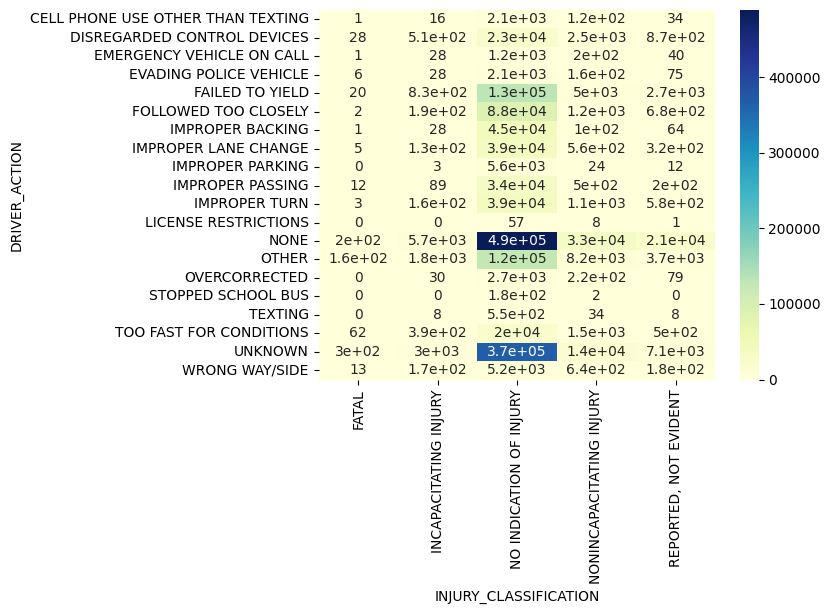

In [41]:
sns.heatmap(pd.crosstab(people_.DRIVER_ACTION, people_.INJURY_CLASSIFICATION),
            annot=True, cmap="YlGnBu");

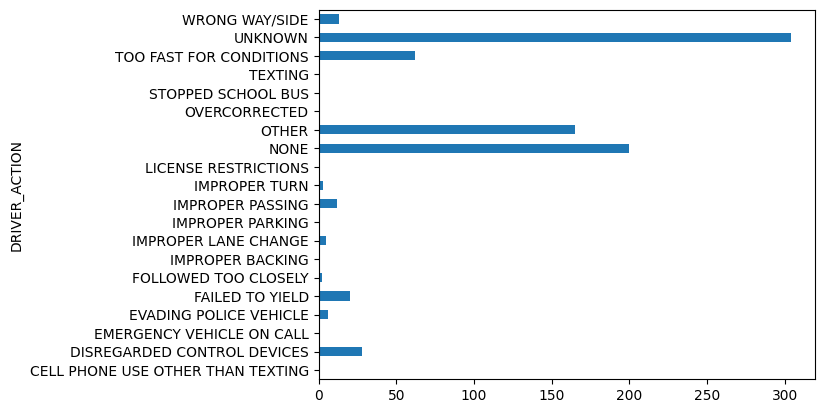

In [42]:
# Driver action with fatalities
pd.crosstab(people_.DRIVER_ACTION, people_.INJURY_CLASSIFICATION)['FATAL'].plot.barh();

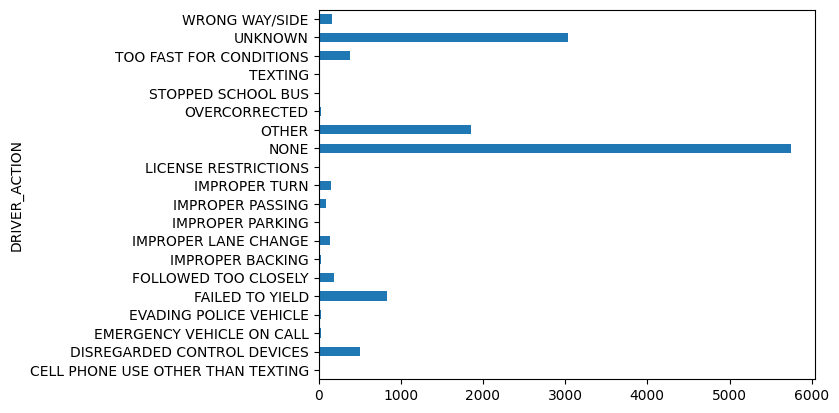

In [43]:
# Driver action with inapacitating injuries
pd.crosstab(people_.DRIVER_ACTION, people_.INJURY_CLASSIFICATION)['INCAPACITATING INJURY'].plot.barh();

In [44]:
# Distribution of breathalyzer tests
people_.BAC_RESULT.value_counts()

BAC_RESULT
TEST NOT OFFERED                   1516974
TEST REFUSED                         15854
TEST PERFORMED, RESULTS UNKNOWN       3660
TEST TAKEN                            2709
Name: count, dtype: int64

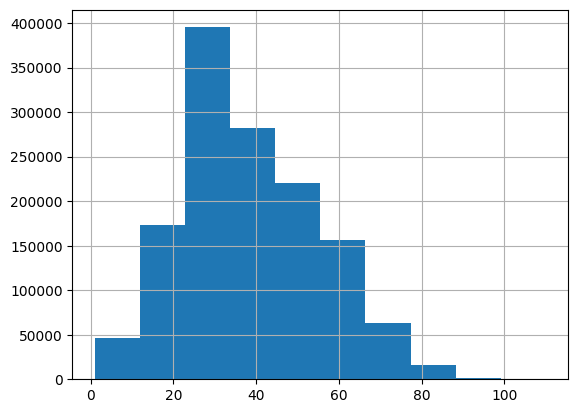

In [45]:
people_df[people_df['AGE'] > 0]['AGE'].hist();

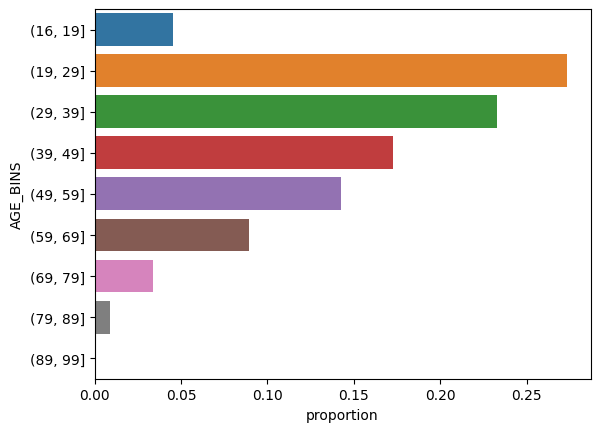

In [46]:
people_df['AGE_BINS'] = pd.cut(x=people_df['AGE'], bins=[16, 19, 29, 39, 49, 59, 69, 79, 89, 99])

sns.barplot(y=people_df.AGE_BINS.value_counts(normalize=True).index, x=people_df.AGE_BINS.value_counts(normalize=True),
           orient='h');

How does Age relate to injury?

In [47]:
pd.crosstab(people_df.AGE_BINS, people_df.INJURY_CLASSIFICATION)

INJURY_CLASSIFICATION,FATAL,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
AGE_BINS,,,,,
"(16, 19]",39,820,49638,4919,2492
"(19, 29]",217,4194,307914,24419,13398
"(29, 39]",190,3292,265783,18308,10878
"(39, 49]",125,2233,199413,12031,7679
"(49, 59]",111,2117,163026,10310,6772
"(59, 69]",88,1485,101631,6894,4128
"(69, 79]",52,652,38704,2608,1447
"(79, 89]",28,226,10310,826,408
"(89, 99]",3,20,1135,100,38


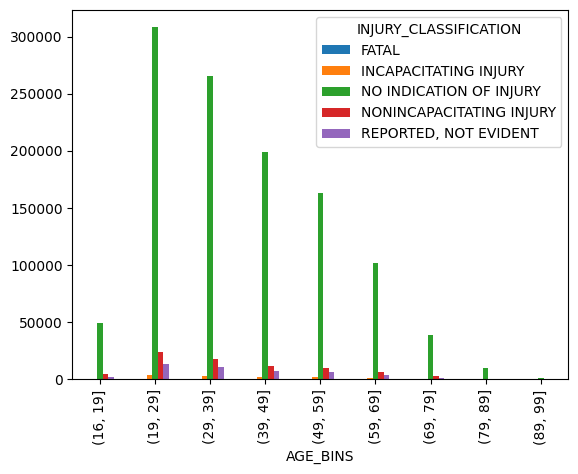

In [48]:
pd.crosstab(people_df.AGE_BINS, people_df.INJURY_CLASSIFICATION).plot.bar();

It appears as though people in their 20s are getting into a lot of wrecks, with all manner of outcomes, with the rate slowing with age. However, we can't conclude from this dataset alone that younger people are more likely to get into crashes. We would need to compare to general driver demographic data to see if this is proportional or not and calculate accident rates.

Our initial models predict that sex is a strong predictor for higher levels of injury/fatalities:

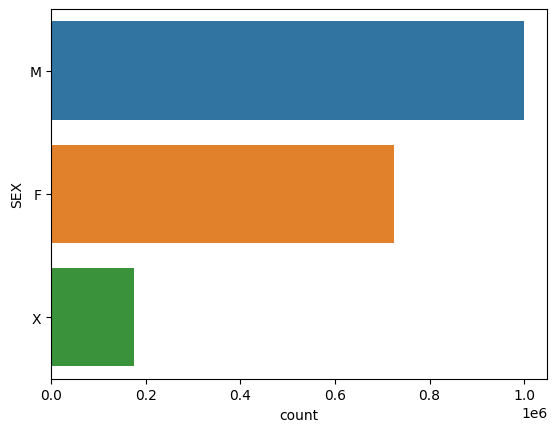

In [49]:
sns.barplot(y=people_df.SEX.value_counts().index, x=people_df.SEX.value_counts(),
           orient='h');

In [50]:
pd.crosstab(people_df.SEX, people_df.INJURY_CLASSIFICATION)

INJURY_CLASSIFICATION,FATAL,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
SEX,,,,,
F,272,7385,643620,45148,29209
M,761,9811,913433,48972,26048
X,14,104,174804,330,204


### Merging all the data into one dataframe

Since we are focusing on predicting the causes that result to crashes, we will merge on `people_selected_df` in the right join with `crashes_selected_df` and `vehicle_selected_df` also on the right. This will allow us to create a `TARGET` column based on the crashes that occurred

In [51]:
vehicle_df.columns

Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL', 'LIC_PLATE_STATE',
       'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE',
       'TRAVEL_DIRECTION', 'MANEUVER', 'OCCUPANT_CNT', 'AREA_01_I',
       'FIRST_CONTACT_POINT'],
      dtype='object')

In [52]:
crashes_selected_df = crashes_df[['CRASH_RECORD_ID', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                                 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 
                                 'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
                                 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 
                                  'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE']]

In [53]:
people_selected_df = people_df[['CRASH_RECORD_ID', 'PERSON_TYPE', 'AGE', 'SEX', 
                                'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'INJURY_CLASSIFICATION', 
                                'PHYSICAL_CONDITION', 'DRIVER_ACTION', 'DRIVER_VISION', 'BAC_RESULT']]

In [54]:
vehicle_selected_df = vehicle_df[['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'UNIT_TYPE', 'VEHICLE_DEFECT', 
                                  'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER', 'MAKE', 
                                  'MODEL', 'OCCUPANT_CNT', 'FIRST_CONTACT_POINT', 'VEHICLE_YEAR']]


In [55]:
crashes_final_df = crashes_selected_df.merge(people_selected_df, on='CRASH_RECORD_ID', how='left')

crashes_final_df = crashes_final_df.merge(vehicle_selected_df, on='CRASH_RECORD_ID', how='left')

crashes_final_df.head()

,CRASH_RECORD_ID,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,...,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,MAKE,MODEL,OCCUPANT_CNT,FIRST_CONTACT_POINT,VEHICLE_YEAR
0,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,DRY,...,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,DODGE,CHALLENGER,1.0,FRONT,2020.0
1,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,DRY,...,UNKNOWN,OTHER,AMBULANCE,E,STRAIGHT AHEAD,FORD,OTHER (EXPLAIN IN NARRATIVE),4.0,SIDE-RIGHT,2017.0
2,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,DRY,...,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,DODGE,CHALLENGER,1.0,FRONT,2020.0
3,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,DRY,...,UNKNOWN,OTHER,AMBULANCE,E,STRAIGHT AHEAD,FORD,OTHER (EXPLAIN IN NARRATIVE),4.0,SIDE-RIGHT,2017.0
4,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,DRY,...,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,DODGE,CHALLENGER,1.0,FRONT,2020.0


In [56]:
missing_values_summary(crashes_final_df)

,Missing Values,Percentage
AGE,1178123,28.996382
DRIVER_VISION,842370,20.732710
DRIVER_ACTION,841065,20.700591
BAC_RESULT,838798,20.644794
PHYSICAL_CONDITION,838671,20.641669
VEHICLE_YEAR,630538,15.519025
FIRST_CONTACT_POINT,103140,2.538518
MODEL,96848,2.383657
MAKE,96463,2.374182
MANEUVER,96451,2.373886


In [57]:
crashes_final_df = crashes_final_df.dropna()

In [58]:
crashes_final_df.shape

(2059471, 40)

In [59]:
crashes_final_df.columns

Index(['CRASH_RECORD_ID', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE',
       'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
       'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'PERSON_TYPE', 'AGE', 'SEX',
       'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'INJURY_CLASSIFICATION',
       'PHYSICAL_CONDITION', 'DRIVER_ACTION', 'DRIVER_VISION', 'BAC_RESULT',
       'CRASH_UNIT_ID', 'UNIT_TYPE', 'VEHICLE_DEFECT', 'VEHICLE_TYPE',
       'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER', 'MAKE', 'MODEL',
       'OCCUPANT_CNT', 'FIRST_CONTACT_POINT', 'VEHICLE_YEAR'],
      dtype='object')

In [60]:
crashes_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2059471 entries, 92 to 4062995
Data columns (total 40 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   CRASH_RECORD_ID          object 
 1   POSTED_SPEED_LIMIT       int64  
 2   TRAFFIC_CONTROL_DEVICE   object 
 3   DEVICE_CONDITION         object 
 4   WEATHER_CONDITION        object 
 5   LIGHTING_CONDITION       object 
 6   FIRST_CRASH_TYPE         object 
 7   TRAFFICWAY_TYPE          object 
 8   ALIGNMENT                object 
 9   ROADWAY_SURFACE_COND     object 
 10  ROAD_DEFECT              object 
 11  PRIM_CONTRIBUTORY_CAUSE  object 
 12  SEC_CONTRIBUTORY_CAUSE   object 
 13  CRASH_HOUR               int64  
 14  CRASH_DAY_OF_WEEK        int64  
 15  CRASH_MONTH              int64  
 16  LATITUDE                 float64
 17  LONGITUDE                float64
 18  PERSON_TYPE              object 
 19  AGE                      float64
 20  SEX                      object 
 21  SAFETY_EQUIP

In [61]:
crashes_final_df.isna().sum()

CRASH_RECORD_ID            0
POSTED_SPEED_LIMIT         0
TRAFFIC_CONTROL_DEVICE     0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
TRAFFICWAY_TYPE            0
ALIGNMENT                  0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CRASH_MONTH                0
LATITUDE                   0
LONGITUDE                  0
PERSON_TYPE                0
AGE                        0
SEX                        0
SAFETY_EQUIPMENT           0
AIRBAG_DEPLOYED            0
INJURY_CLASSIFICATION      0
PHYSICAL_CONDITION         0
DRIVER_ACTION              0
DRIVER_VISION              0
BAC_RESULT                 0
CRASH_UNIT_ID              0
UNIT_TYPE                  0
VEHICLE_DEFECT             0
VEHICLE_TYPE               0
VEHICLE_USE                0
TRAVEL_DIRECTION           0
MANEUVER      

Checking for duplicates

In [62]:
duplicate_rows = crashes_final_df[crashes_final_df.duplicated()]
print(duplicate_rows)

                                           CRASH_RECORD_ID  \
5573     111f4bc6f4e8781f355493e263b1202ae75b7c28808db0...   
5574     111f4bc6f4e8781f355493e263b1202ae75b7c28808db0...   
10440    2277f2cb8995912e4b3259ccad036dcbb49371abd361a5...   
10441    2277f2cb8995912e4b3259ccad036dcbb49371abd361a5...   
15363    3c4e5e8c63b25479029f522747fef11cffdbcf3b861ffa...   
...                                                    ...   
4062932  61c8dcd63fae60613bc9ec526fa901420cbe99a6d35840...   
4062933  61c8dcd63fae60613bc9ec526fa901420cbe99a6d35840...   
4062934  61c8dcd63fae60613bc9ec526fa901420cbe99a6d35840...   
4062955  cb0ca76762ca65feacb1f6513312f96f2a05629bd8a866...   
4062957  cb0ca76762ca65feacb1f6513312f96f2a05629bd8a866...   

         POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION  \
5573                     30            NO CONTROLS           NO CONTROLS   
5574                     30            NO CONTROLS           NO CONTROLS   
10440                    30

From the above output, there are 11196 rows that are duplicates

Remove all the duplicates from the dataset

In [63]:
# Remove all duplicates based on all columns
def remove_all_duplicates(df):
    original_shape = df.shape
    df_no_duplicates = df.drop_duplicates()
    removed_count = original_shape[0] - df_no_duplicates.shape[0]
    
    print(f"Original number of rows: {original_shape[0]}")
    print(f"Number of rows after removing duplicates: {df_no_duplicates.shape[0]}")
    print(f"Number of duplicate rows removed: {removed_count}")
    
    return df_no_duplicates

In [64]:
crashes_final_df = remove_all_duplicates(crashes_final_df)

Original number of rows: 2059471
Number of rows after removing duplicates: 2048275
Number of duplicate rows removed: 11196


In [65]:
crashes_final_df.duplicated().sum()

0

There are now no duplicates in our dataset. The number of duplicates were found to be 11196. After removal of the duplicates, the number of rows reduced to 2048275 from 2059471  
We now going to analyze the column values of our dataset

In [66]:
def analyze_column_values(df):
    for column in df.columns:
        unique_values = df[column].unique()
        n_unique = len(unique_values)
        
        print(f"\n{'='*50}")
        print(f"Column: {column}")
        print(f"Number of unique values: {n_unique}")
        print(f"Data type: {df[column].dtype}")
        
        # For numerical columns, show statistics
        if np.issubdtype(df[column].dtype, np.number):
            print(f"Min: {df[column].min()}")
            print(f"Max: {df[column].max()}")
            print(f"Mean: {df[column].mean():.2f}")
            print("Sample values:", unique_values[:5] if n_unique > 5 else unique_values)
        
        # For categorical/object columns
        else:
            # If too many unique values, show sample and value counts
            if n_unique > 20:
                print("Top 10 most common values:")
                print(df[column].value_counts().nlargest(10))
                print(f"\nSample values: {unique_values[:5]}")
            else:
                print("All unique values:")
                for value in unique_values:
                    count = df[column].value_counts()[value]
                    print(f"- {value}: {count} occurrences")

In [67]:
def get_unique_crash_records(df):

    # Count duplicates before removal
    duplicate_count = df[df.duplicated(subset=['CRASH_RECORD_ID'])]['CRASH_RECORD_ID'].count()
    
    # Keep only the first occurrence of each CRASH_RECORD_ID
    df_unique = df.drop_duplicates(subset=['CRASH_RECORD_ID'], keep='first')
    
    return df_unique

In [68]:
crashes_final_df = get_unique_crash_records(crashes_final_df)

In [69]:
crashes_final_df.shape

(679175, 40)

In [70]:
analyze_column_values(crashes_final_df)


Column: CRASH_RECORD_ID
Number of unique values: 679175
Data type: object
Top 10 most common values:
CRASH_RECORD_ID
37b7acd5f2db6728ca4ac0d7e4217f78b6703f769754b495c437ace10d472977fe4ad4973167dd364031c0641830c0d163bd382d7c6927e2669619ce77051f65    1
fd05285e9d273fe20cbbebf84794045828a2ba589073b6c92a05f7656d6a31172e5e79847caf4c04f3bebf91ed7f2cab1a871cf53690f71f3d940f839a1c8fc4    1
fda2491d33ac819033f4aaa7ed901120f2f6785b7e5bbbbf99eb6d56847d5de207d7697261a182f12a2a47fbeb3fbaa5c3c767d3ac099675e65e09f345b7e7f4    1
4a1f7a24129e5e1d4a7a2fd44ab6f8822a20bcdb2f627f490af8975d8c14e9fadf2d7b533a09a7e8c2cc57a4b3563803d7d4eb4db3892337cf233f1f0f154013    1
1ee2180a89cc02c0b756f95b5b2755bb5cc9d93450f5caafaee5cb5c6aa75adafd251402ac205833ff78be9c9a0eb799f33d9c854975cf3a8e10c6a7d28116c7    1
64063a32537af636c3a234b85f6a67ecb159a34af31da51f86961959bce9cec811ae891cdf9c519c462e883749757bf53239ce9e74942d8d1e73cb81ea3dc859    1
5590930e0c8de54aff531280946aebabcdd5ce798a37bba57e348767963ab9972abc4995b39885

In [71]:
# Statistical summary
crashes_final_df.describe()

,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,AGE,CRASH_UNIT_ID,OCCUPANT_CNT,VEHICLE_YEAR
count,679175.000000,679175.000000,679175.000000,679175.000000,679175.000000,679175.000000,679175.000000,6.791750e+05,679175.000000,679175.000000
mean,28.889597,13.379818,4.145671,6.646551,41.855292,-87.672316,39.718182,9.516257e+05,1.229396,2013.606969
std,5.704331,5.380915,1.958812,3.367396,0.358708,0.731732,16.214324,5.605961e+05,0.691826,134.855076
min,0.000000,0.000000,1.000000,1.000000,0.000000,-87.936193,-49.000000,2.000000e+00,0.000000,1900.000000
25%,30.000000,10.000000,2.000000,4.000000,41.784982,-87.721053,27.000000,4.620955e+05,1.000000,2007.000000
50%,30.000000,14.000000,4.000000,7.000000,41.875188,-87.673272,37.000000,9.460450e+05,1.000000,2012.000000
75%,30.000000,17.000000,6.000000,9.000000,41.924854,-87.632942,51.000000,1.440792e+06,1.000000,2016.000000
max,99.000000,23.000000,7.000000,12.000000,42.022780,0.000000,110.000000,1.923903e+06,43.000000,9999.000000


In [72]:
crashes_final_df.columns

Index(['CRASH_RECORD_ID', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE',
       'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
       'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'PERSON_TYPE', 'AGE', 'SEX',
       'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'INJURY_CLASSIFICATION',
       'PHYSICAL_CONDITION', 'DRIVER_ACTION', 'DRIVER_VISION', 'BAC_RESULT',
       'CRASH_UNIT_ID', 'UNIT_TYPE', 'VEHICLE_DEFECT', 'VEHICLE_TYPE',
       'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER', 'MAKE', 'MODEL',
       'OCCUPANT_CNT', 'FIRST_CONTACT_POINT', 'VEHICLE_YEAR'],
      dtype='object')